# Face Classification using PCA and LDA

This notebook demonstrates face recognition techniques using Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA).

## 1. Import Libraries

In [1]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import re

# Set plot style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

## 2. Check Working Directory and Load Data

In [2]:
# Debug: confirm working directory and files
print("Working directory:", os.getcwd())
print("Directory contents:", os.listdir())

Working directory: F:\OneDrive - University of Patras\CEID\10ο Εξάμηνο\ΕΦΑΡΜΟΓΕΣ ΨΗΦΙΑΚΗΣ ΕΠΕΞΕΡΓΑΣΙΑΣ ΣΗΜΑΤΩΝ\ASKISI 4\ADSP_4-LDA
Directory contents: ['ADSP_PCA_LDA_k_means_cor.pdf', 'classification_results', 'faces_dataset', 'face_classification.ipynb', 'face_classification.py', 'gender_classification.py', 'gender_map.json', 'make_splits.py', 'person_recognition_results', 'person_splits.json', 'report template.docx', 'report template.pdf', 'splits.json', 'test_json_load.py', 'visualization_results']


In [3]:
# Load existing splits.json
with open("splits.json", "r") as f:
    gender_splits = json.load(f)

## 3. Create Person Splits

We'll organize the dataset by person and create training/testing splits.

In [4]:
# Function to extract person ID from path using regex
def extract_person_id(path):
    match = re.search(r'faces_dataset\\s(\d+)\\', path)
    if match:
        return f"person_{match.group(1)}"
    return None

In [5]:
def create_person_splits(gender_splits):
    person_splits = {"train": [], "test": []}

    # Group all images by person ID
    persons_data = {}

    # Collect all images grouped by person
    for item in gender_splits["train"] + gender_splits["test"]:
        match = re.search(r'faces_dataset\\s(\d+)\\', item["path"])
        if match:
            person_id = f"person_{match.group(1)}"

            # Initialize entry for this person if not seen before
            if person_id not in persons_data:
                persons_data[person_id] = []

            # Get directory part
            dir_part = item["path"].rsplit('\\', 1)[0]

            # Add sequential images for this person
            current_index = len(persons_data[person_id]) + 1
            new_path = f"{dir_part}\\{current_index}.pgm"

            persons_data[person_id].append({
                "path": new_path,
                "label": person_id
            })

    # Now randomly split each person's images into train/test with 70/30 ratio
    np.random.seed(42)  # For reproducibility

    for person_id, images in persons_data.items():
        # Shuffle the images
        np.random.shuffle(images)

        # Calculate split point (70% train, 30% test)
        split_idx = int(0.7 * len(images))

        # Split into train and test
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        # Add to the final splits
        person_splits["train"].extend(train_images)
        person_splits["test"].extend(test_images)

    print(f"Created splits: {len(person_splits['train'])} training images, {len(person_splits['test'])} test images")
    return person_splits

In [6]:
# Create person splits
person_splits = create_person_splits(gender_splits)

# Save the person_splits to a JSON file
with open("person_splits.json", "w") as f:
    json.dump(person_splits, f, indent=2)

print("Successfully created and saved person_splits.json")

Created splits: 280 training images, 120 test images
Successfully created and saved person_splits.json


## 4. Load and Preprocess Data

In [7]:
# Load & center data
def load_set(key, splits_data):
    X, y = [], []
    for e in splits_data[key]:
        try:
            img = np.array(Image.open(e["path"]), dtype=float).flatten()
            X.append(img)
            y.append(e["label"])
        except FileNotFoundError:
            print(f"Warning: File not found: {e['path']}")
    return np.vstack(X), np.array(y)

In [8]:
X_train, y_train = load_set("train", person_splits)
X_test, y_test = load_set("test", person_splits)

# Get original image dimensions
first_img = Image.open(person_splits["train"][0]["path"])
width, height = first_img.size

# Compute mean face and center data
mean_face = X_train.mean(axis=0)
X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face

# Encode labels for multi-class classification
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# Create results directory if it doesn't exist
results_dir = "person_recognition_results"
os.makedirs(results_dir, exist_ok=True)

# Output information about the dataset
n_classes = len(np.unique(y_train_enc))
print(f"Number of persons: {n_classes}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Number of persons: 40
Training samples: 280
Test samples: 120


## 5. PCA Analysis and Visualization for Person Recognition

In [9]:
print("\n=== PCA Analysis for Person Recognition ===")
n_components_full = min(X_train.shape[0], X_train.shape[1])
pca_full = PCA(n_components=n_components_full)
pca_full.fit(X_train_centered)


=== PCA Analysis for Person Recognition ===


PCA(n_components=280)

### 5.1. Eigenvalue Spectrum Visualization

Components needed for 95% variance: 148
Components needed for 99% variance: 235


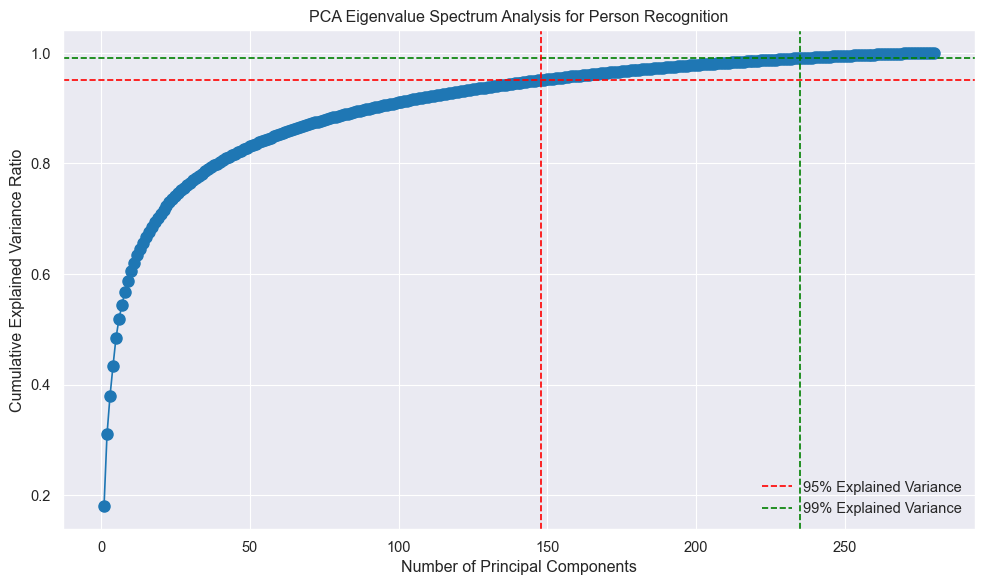

In [10]:
plt.figure(figsize=(10, 6))
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
plt.plot(range(1, len(explained_var) + 1), cumulative_var, 'o-', markersize=8)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance')
components_95 = np.where(cumulative_var >= 0.95)[0][0] + 1
components_99 = np.where(cumulative_var >= 0.99)[0][0] + 1
plt.axvline(x=components_95, color='r', linestyle='--')
plt.axvline(x=components_99, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Eigenvalue Spectrum Analysis for Person Recognition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{results_dir}/pca_eigenvalue_spectrum.png", dpi=300)

print(f"Components needed for 95% variance: {components_95}")
print(f"Components needed for 99% variance: {components_99}")

### 5.2. Top Eigenfaces Visualization

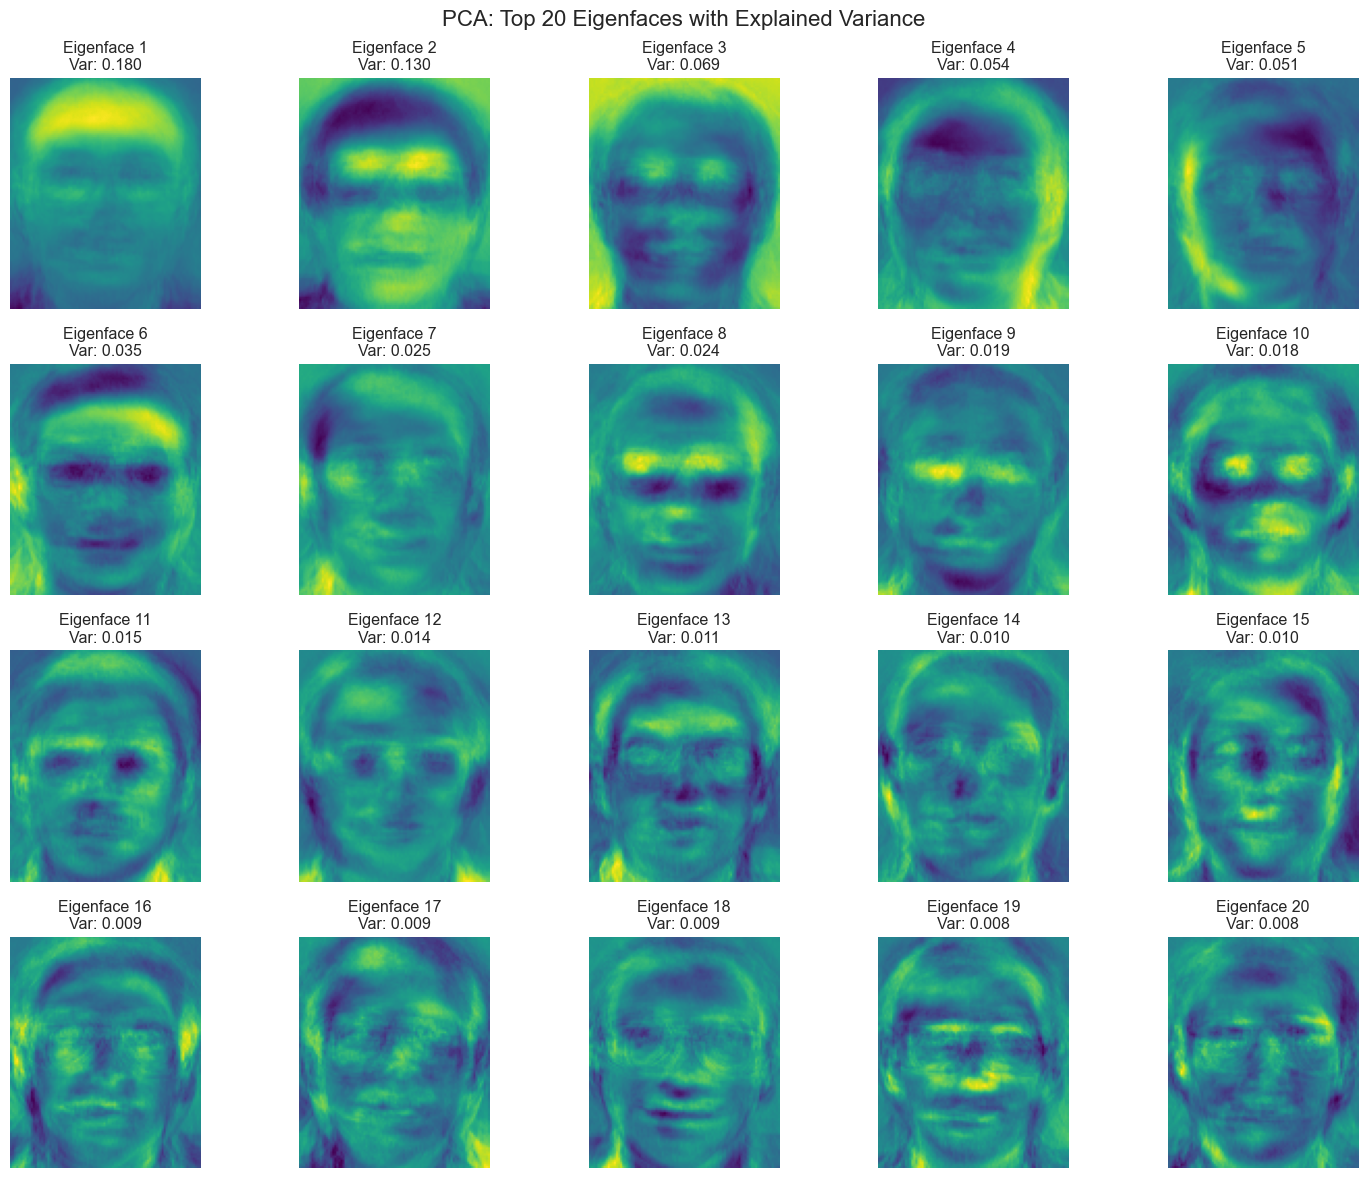

In [11]:
n_eigenfaces = min(20, len(explained_var))
pca = PCA(n_components=n_eigenfaces, svd_solver="randomized", whiten=True)
Z_train = pca.fit_transform(X_train_centered)
Z_test = pca.transform(X_test_centered)

# Eigenfaces grid
eigs = pca.components_.reshape((n_eigenfaces, height, width))
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < n_eigenfaces:
        ax.imshow(eigs[i], cmap="viridis")
        ax.set_title(f"Eigenface {i + 1}\nVar: {pca.explained_variance_ratio_[i]:.3f}")
        ax.axis("off")
    else:
        ax.axis("off")
plt.suptitle("PCA: Top 20 Eigenfaces with Explained Variance", fontsize=16)
plt.tight_layout()
plt.savefig(f"{results_dir}/eigenfaces_grid.png", dpi=300)

### 5.3. Face Reconstruction with Increasing Eigenfaces

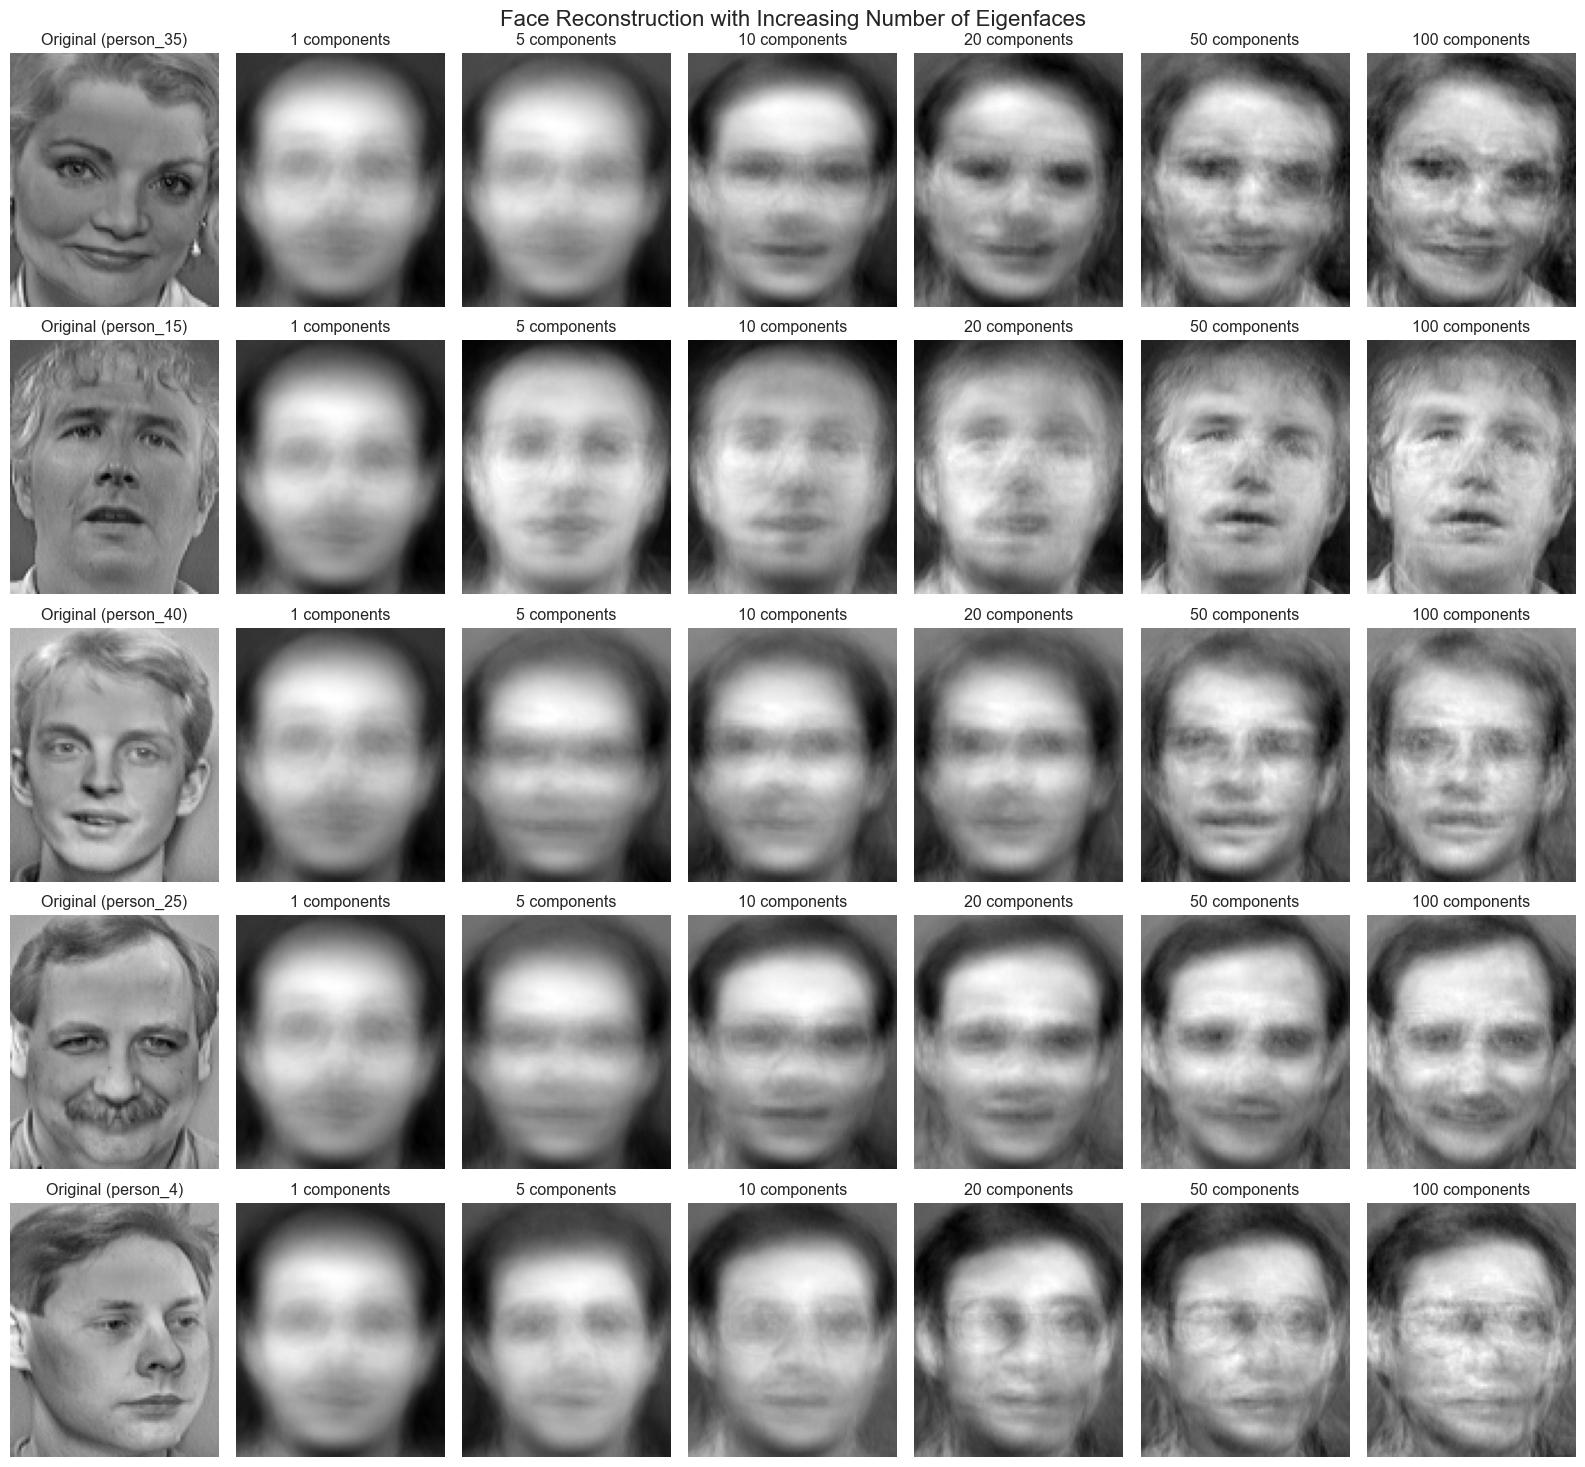

In [12]:
n_reconstructions = 5  # Number of faces to reconstruct
reconstruction_steps = [1, 5, 10, 20, 50, 100]  # Number of eigenfaces to use

# Get some test faces
test_faces_indices = np.random.choice(len(X_test), n_reconstructions, replace=False)
test_faces = X_test_centered[test_faces_indices]
test_labels = y_test[test_faces_indices]

# Create a larger PCA model for reconstruction
if max(reconstruction_steps) > n_eigenfaces:
    pca_recon = PCA(n_components=max(reconstruction_steps))
    pca_recon.fit(X_train_centered)
else:
    pca_recon = pca

# Plot reconstructions
fig, axes = plt.subplots(n_reconstructions, len(reconstruction_steps) + 1,
                         figsize=(16, 3 * n_reconstructions))

for i, face_idx in enumerate(range(n_reconstructions)):
    # Original face
    orig_face = test_faces[face_idx].reshape(height, width)
    axes[i, 0].imshow(orig_face, cmap='gray')
    axes[i, 0].set_title(f"Original ({test_labels[face_idx]})")
    axes[i, 0].axis('off')

    # Reconstructions with increasing eigenvectors
    for j, n_components in enumerate(reconstruction_steps):
        # Project to eigenspace and back
        reduced = pca_recon.transform(test_faces[face_idx].reshape(1, -1))[:, :n_components]
        reconstructed = np.dot(reduced, pca_recon.components_[:n_components, :]) + mean_face
        reconstructed = reconstructed.reshape(height, width)

        # Display reconstruction
        axes[i, j + 1].imshow(reconstructed, cmap='gray')
        axes[i, j + 1].set_title(f"{n_components} components")
        axes[i, j + 1].axis('off')

plt.suptitle("Face Reconstruction with Increasing Number of Eigenfaces", fontsize=16)
plt.tight_layout()
plt.savefig(f"{results_dir}/face_reconstruction.png", dpi=300)

### 5.4. Visualize Data with t-SNE


=== t-SNE Visualization of PCA Features ===


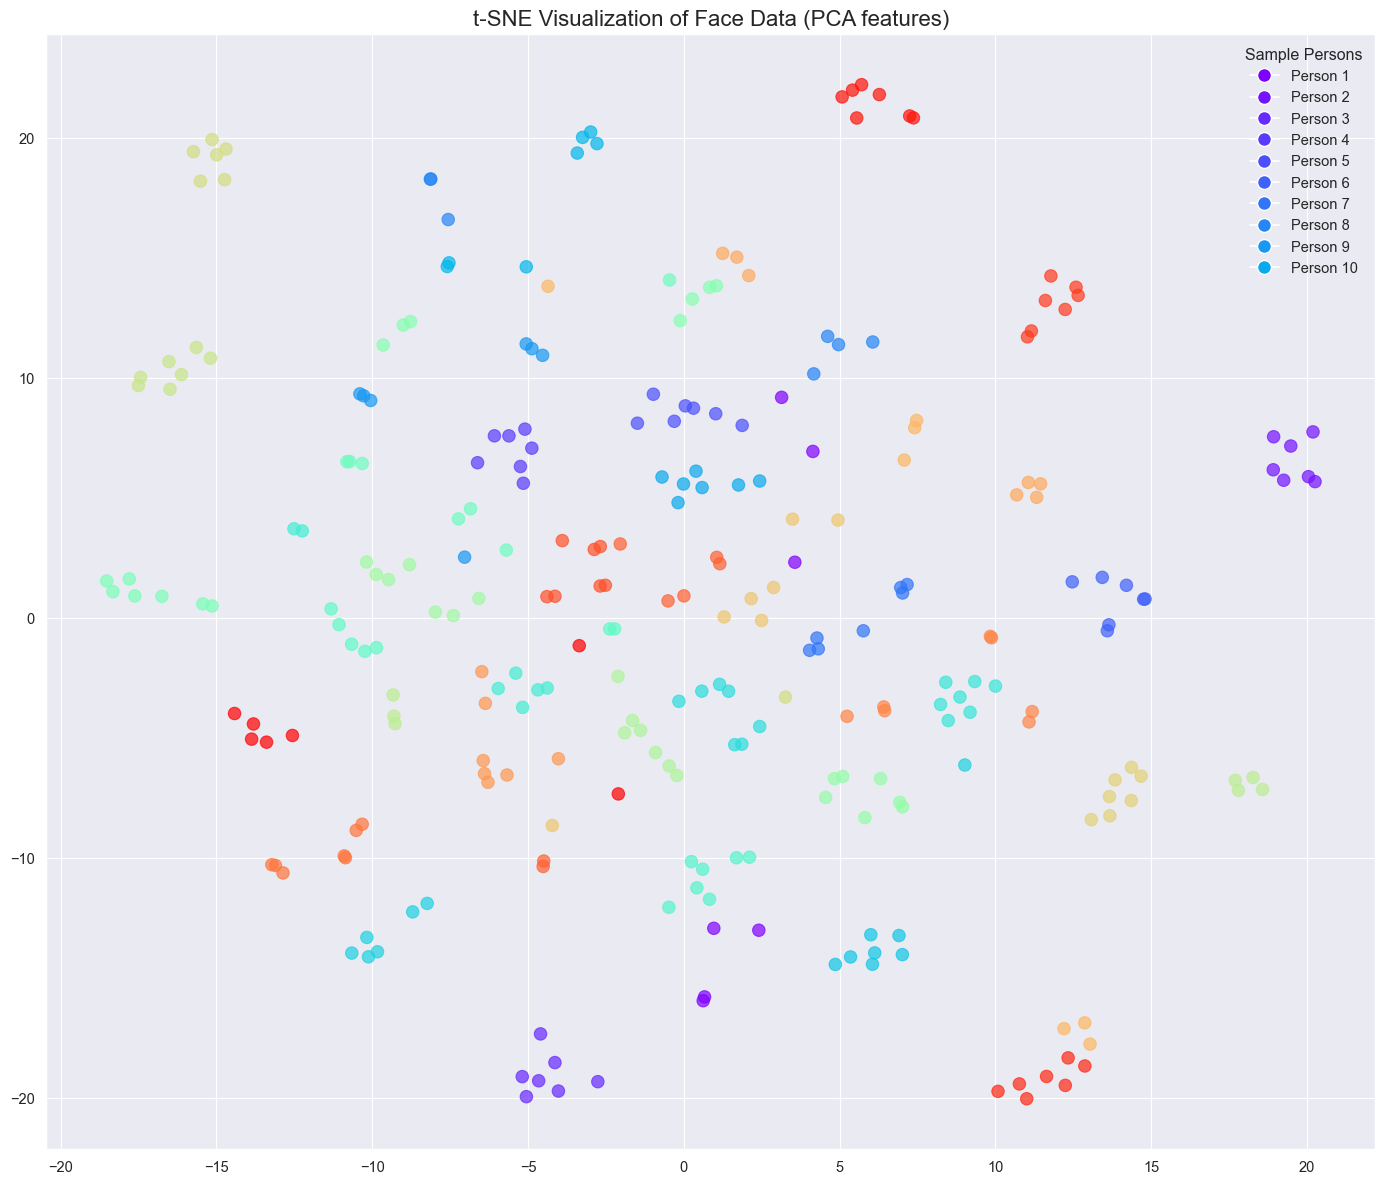

In [13]:
print("\n=== t-SNE Visualization of PCA Features ===")
# Use first 50 PCA components for t-SNE input
n_pca_for_tsne = min(50, Z_train.shape[1])
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
Z_train_tsne = tsne.fit_transform(Z_train[:, :n_pca_for_tsne])

# Create a colormap with distinct colors for all people
n_classes = len(np.unique(y_train_enc))
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
cmap = ListedColormap(colors)

# Plot t-SNE visualization
plt.figure(figsize=(14, 12))
scatter = plt.scatter(Z_train_tsne[:, 0], Z_train_tsne[:, 1],
                      c=y_train_enc, cmap=cmap,
                      s=80, alpha=0.7)

# Add legend (but limit to first 10 persons to avoid clutter)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=colors[i], markersize=10,
                              label=f'Person {i + 1}')
                   for i in range(min(10, n_classes))]
plt.legend(handles=legend_elements, loc='best', title="Sample Persons")

plt.title('t-SNE Visualization of Face Data (PCA features)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_dir}/tsne_pca_visualization.png", dpi=300)

### 5.5. Train a 1-NN Classifier on the PCA Projection

In [14]:
knn_pca = KNeighborsClassifier(n_neighbors=1).fit(Z_train, y_train)
pred_pca = knn_pca.predict(Z_test)
pca_accuracy = accuracy_score(y_test, pred_pca)
print(f"PCA + 1-NN Accuracy: {pca_accuracy:.4f}")

PCA + 1-NN Accuracy: 0.9167


## 6. LDA Analysis and Visualization for Person Recognition

In [15]:
print("\n=== LDA Analysis for Person Recognition ===")
# For multi-class, we can use more components (up to n_classes - 1)
n_components_lda = min(n_classes - 1, X_train.shape[1])
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
L_train = lda.fit_transform(X_train_centered, y_train_enc)
L_test = lda.transform(X_test_centered)


=== LDA Analysis for Person Recognition ===


### 6.1. Visualize Top Fisherfaces

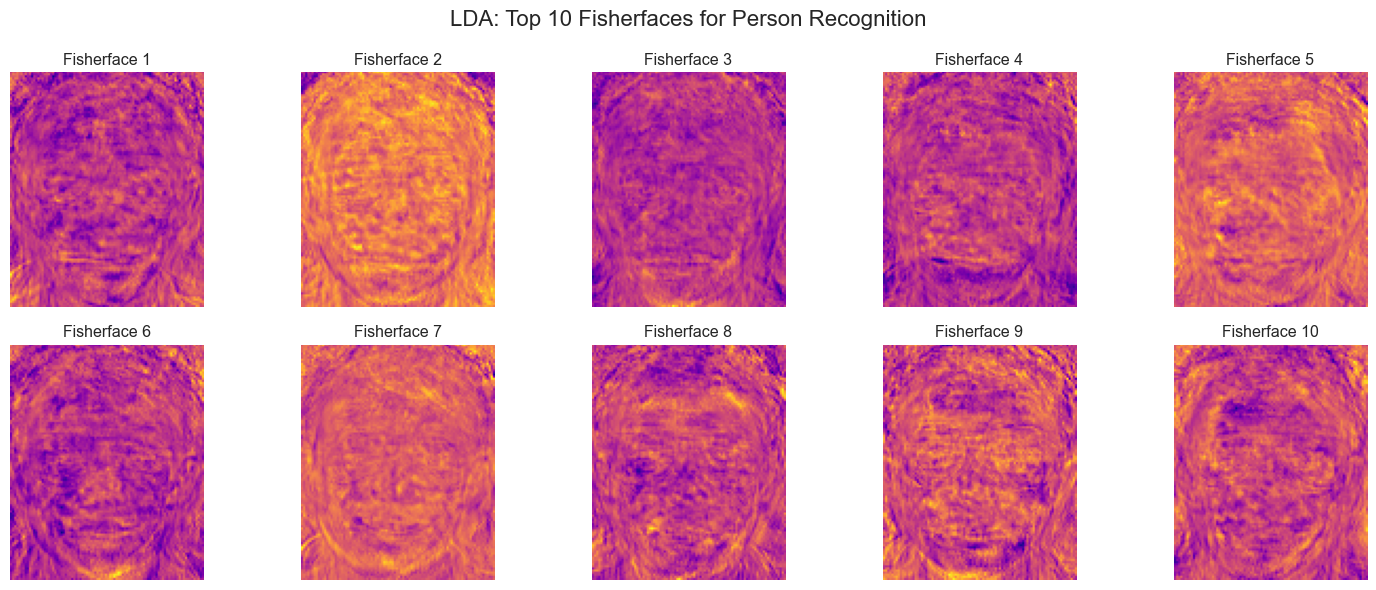

In [16]:
n_fisherfaces = min(10, n_components_lda)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < n_fisherfaces:
        fisherface = lda.scalings_[:, i].reshape((height, width))
        ax.imshow(fisherface, cmap="plasma")
        ax.set_title(f"Fisherface {i + 1}")
        ax.axis("off")
    else:
        ax.axis("off")
plt.suptitle("LDA: Top 10 Fisherfaces for Person Recognition", fontsize=16)
plt.tight_layout()
plt.savefig(f"{results_dir}/fisherfaces.png", dpi=300)

### 6.2. Visualize LDA Projection with t-SNE

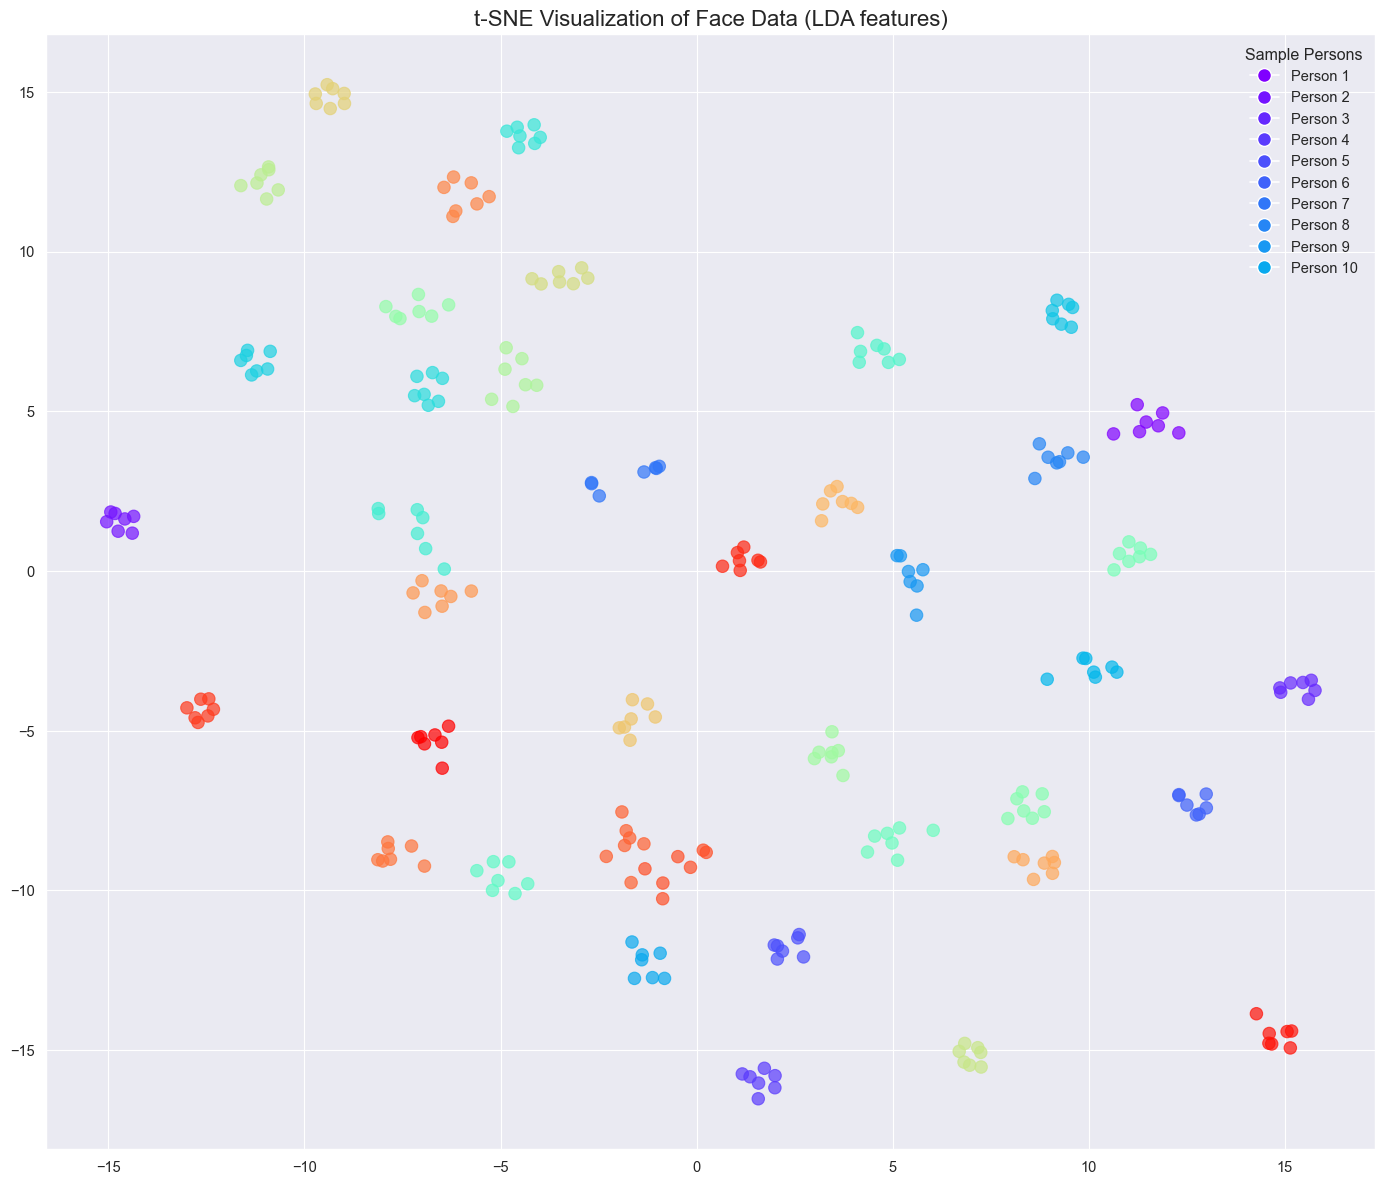

In [17]:
if L_train.shape[1] > 1:
    # If we have multiple LDA components, use t-SNE for visualization
    n_lda_for_tsne = min(L_train.shape[1], 20)
    tsne_lda = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    L_train_tsne = tsne_lda.fit_transform(L_train[:, :n_lda_for_tsne])

    plt.figure(figsize=(14, 12))
    scatter = plt.scatter(L_train_tsne[:, 0], L_train_tsne[:, 1],
                          c=y_train_enc, cmap=cmap,
                          s=80, alpha=0.7)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=colors[i], markersize=10,
                                  label=f'Person {i + 1}')
                       for i in range(min(10, n_classes))]
    plt.legend(handles=legend_elements, loc='best', title="Sample Persons")

    plt.title('t-SNE Visualization of Face Data (LDA features)', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{results_dir}/tsne_lda_visualization.png", dpi=300)

### 6.3. Train a 1-NN Classifier on the LDA Projection

In [18]:
knn_lda = KNeighborsClassifier(n_neighbors=1).fit(L_train, y_train)
pred_lda = knn_lda.predict(L_test)
lda_accuracy = accuracy_score(y_test, pred_lda)
print(f"LDA + 1-NN Accuracy: {lda_accuracy:.4f}")

LDA + 1-NN Accuracy: 0.9667


## 7. Centroid Classifier for Person Recognition

In [19]:
print("\n=== Centroid Classifier Analysis for Person Recognition ===")


=== Centroid Classifier Analysis for Person Recognition ===


### 7.1. Calculate Centroids for Each Person

In [20]:
centroids = {}
for person_id in range(n_classes):
    person_mask = (y_train_enc == person_id)
    person_samples = X_train_centered[person_mask]
    centroids[person_id] = np.mean(person_samples, axis=0)

### 7.2. Visualize Class Mean Faces (Centroids)

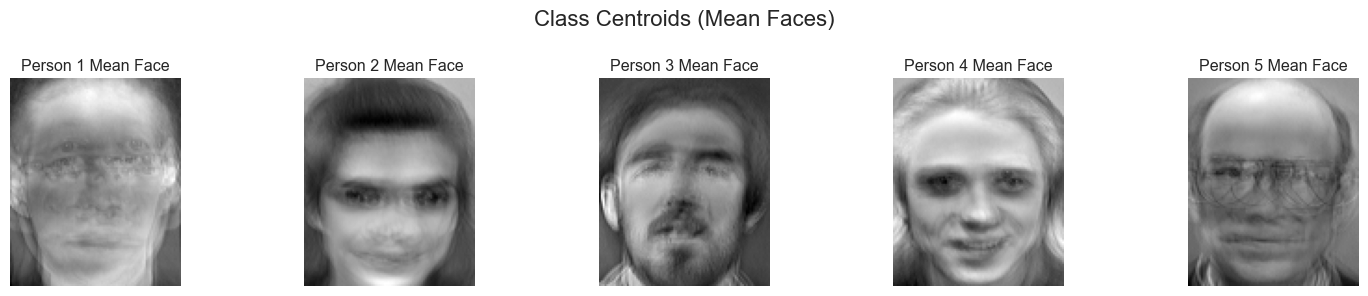

In [21]:
n_persons_to_display = min(5, n_classes)
fig, axes = plt.subplots(1, n_persons_to_display, figsize=(15, 3))
for i in range(n_persons_to_display):
    person_centroid = centroids[i].reshape((height, width))
    axes[i].imshow(person_centroid, cmap="gray")
    axes[i].set_title(f"Person {i + 1} Mean Face")
    axes[i].axis("off")

plt.suptitle("Class Centroids (Mean Faces)", fontsize=16)
plt.tight_layout()
plt.savefig(f"{results_dir}/person_centroids.png", dpi=300)

### 7.3. Predict with Centroid Classifier

In [22]:
def predict_centroid(X, centroids, le):
    predictions = []
    for x in X:
        # Calculate distance to each centroid
        distances = {person_id: np.linalg.norm(x - centroid)
                     for person_id, centroid in centroids.items()}
        # Find closest centroid
        closest_id = min(distances, key=distances.get)
        predictions.append(le.inverse_transform([closest_id])[0])
    return np.array(predictions)

pred_centroid = predict_centroid(X_test_centered, centroids, le)
centroid_accuracy = accuracy_score(y_test, pred_centroid)
print(f"Centroid Classifier Accuracy: {centroid_accuracy:.4f}")

Centroid Classifier Accuracy: 0.9083


## 8. K-means Clustering Analysis

In [23]:
print("\n=== K-means Clustering Analysis for Person Recognition ===")


=== K-means Clustering Analysis for Person Recognition ===


### 8.1. Apply K-means to PCA-projected Data

In [24]:
n_clusters = n_classes  # Number of persons
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_pca = kmeans_pca.fit_predict(Z_train)

### 8.2. Visualize Clusters vs. True Person IDs

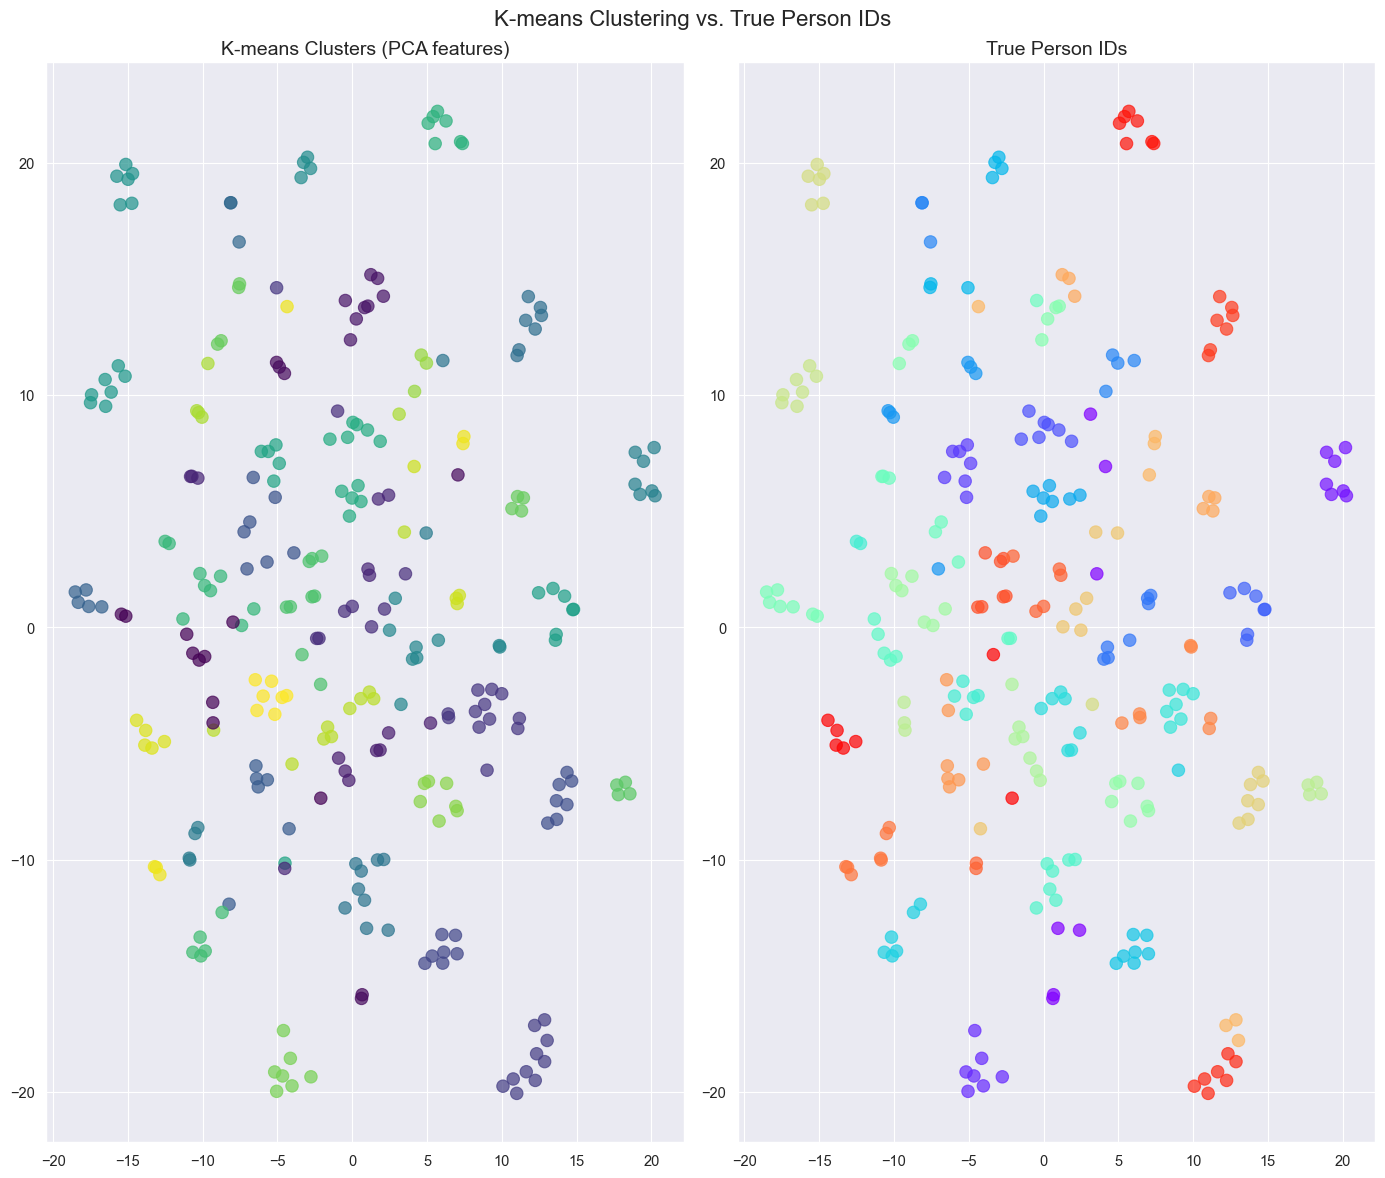

In [25]:
plt.figure(figsize=(14, 12))
plt.subplot(1, 2, 1)
plt.scatter(Z_train_tsne[:, 0], Z_train_tsne[:, 1],
            c=cluster_labels_pca, cmap='viridis',
            s=80, alpha=0.7)
plt.title('K-means Clusters (PCA features)', fontsize=14)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(Z_train_tsne[:, 0], Z_train_tsne[:, 1],
            c=y_train_enc, cmap=cmap,
            s=80, alpha=0.7)
plt.title('True Person IDs', fontsize=14)
plt.grid(True)

plt.suptitle('K-means Clustering vs. True Person IDs', fontsize=16)
plt.tight_layout()
plt.savefig(f"{results_dir}/kmeans_vs_true_labels.png", dpi=300)

### 8.3. Evaluate Clustering Quality

In [26]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_train_enc, cluster_labels_pca)
nmi = normalized_mutual_info_score(y_train_enc, cluster_labels_pca)

print(f"Clustering Quality - Adjusted Rand Index: {ari:.4f}")
print(f"Clustering Quality - Normalized Mutual Info: {nmi:.4f}")

Clustering Quality - Adjusted Rand Index: 0.5444
Clustering Quality - Normalized Mutual Info: 0.8332


## 9. Comparative Performance Analysis

In [27]:
print("\n=== Comparative Performance Analysis ===")


=== Comparative Performance Analysis ===


### 9.1. Calculate Metrics for All Methods

In [28]:
methods = {
    "PCA + 1-NN": pred_pca,
    "LDA + 1-NN": pred_lda,
    "Centroid": pred_centroid
}

accuracies = {name: accuracy_score(y_test, pred) for name, pred in methods.items()}

### 9.2. Generate Comparison Bar Plot

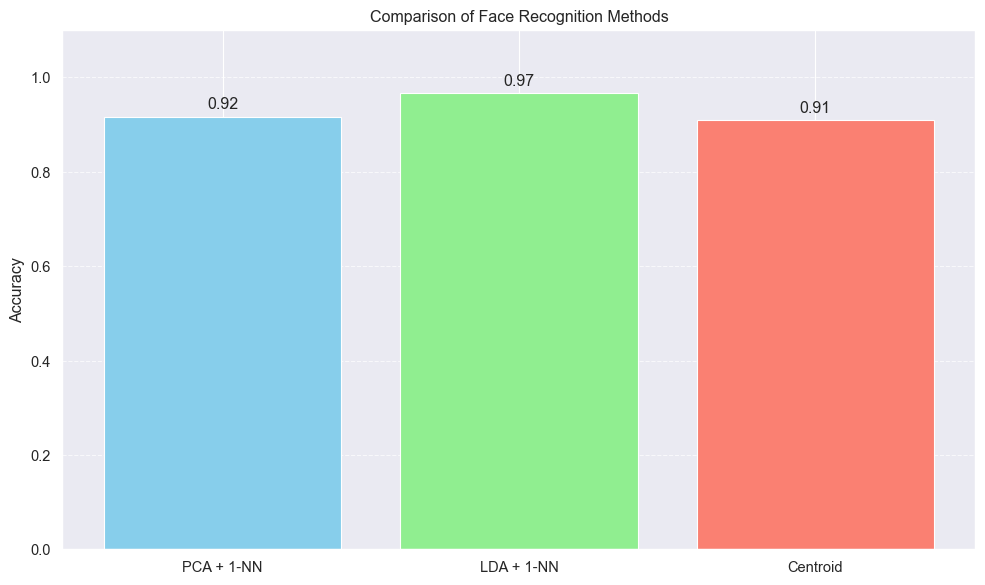

In [29]:
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(),
               color=['skyblue', 'lightgreen', 'salmon'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Comparison of Face Recognition Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{results_dir}/method_comparison.png", dpi=300)

## 10. Visualization of Misclassified Examples

In [30]:
print("\n=== Misclassification Analysis ===")

def plot_misclassified_examples(X_test, y_test, y_pred, method_name, le):
    # Find incorrect predictions
    incorrect = (y_test != y_pred)
    n_incorrect = sum(incorrect)

    # Hard-code image dimensions based on the data
    img_height = 112
    img_width = 92

    if n_incorrect > 0:
        # Get indices of misclassified examples
        incorrect_indices = np.where(incorrect)[0]
        n_examples = min(5, n_incorrect)

        fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3 * n_examples))
        if n_examples == 1:
            axes = axes.reshape(1, 3)

        for i, idx in enumerate(incorrect_indices[:n_examples]):
            # Original image - fix the reshaping issue
            img_flat = X_test[idx] + mean_face
            # Use hardcoded dimensions for reshaping
            img = img_flat.reshape((img_height, img_width))

            axes[i, 0].imshow(img, cmap='gray')

            # Extract person IDs from labels
            true_label = y_test[idx]
            pred_label = y_pred[idx]
            true_id = int(re.search(r'person_(\d+)', true_label).group(1))
            pred_id = int(re.search(r'person_(\d+)', pred_label).group(1))

            axes[i, 0].set_title(f"True: Person {true_id}, Predicted: Person {pred_id}")
            axes[i, 0].axis('off')

            # True person's mean face
            true_enc = le.transform([true_label])[0]
            true_centroid_flat = centroids[true_enc]
            true_person_centroid = true_centroid_flat.reshape((img_height, img_width))
            axes[i, 1].imshow(true_person_centroid, cmap='gray')
            axes[i, 1].set_title(f"Mean Face: Person {true_id}")
            axes[i, 1].axis('off')

            # Wrongly predicted person's mean face
            pred_enc = le.transform([pred_label])[0]
            pred_centroid_flat = centroids[pred_enc]
            pred_person_centroid = pred_centroid_flat.reshape((img_height, img_width))
            axes[i, 2].imshow(pred_person_centroid, cmap='gray')
            axes[i, 2].set_title(f"Mean Face: Person {pred_id}")
            axes[i, 2].axis('off')

        plt.suptitle(f"Misclassified Examples - {method_name}", fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{results_dir}/{method_name.lower().replace(' ', '_')}_misclassified.png", dpi=300)

        return n_incorrect
    else:
        print(f"No misclassifications for {method_name}!")
        return 0


=== Misclassification Analysis ===


PCA + 1-NN: 10 misclassifications out of 120 test samples
LDA + 1-NN: 4 misclassifications out of 120 test samples
Centroid: 11 misclassifications out of 120 test samples


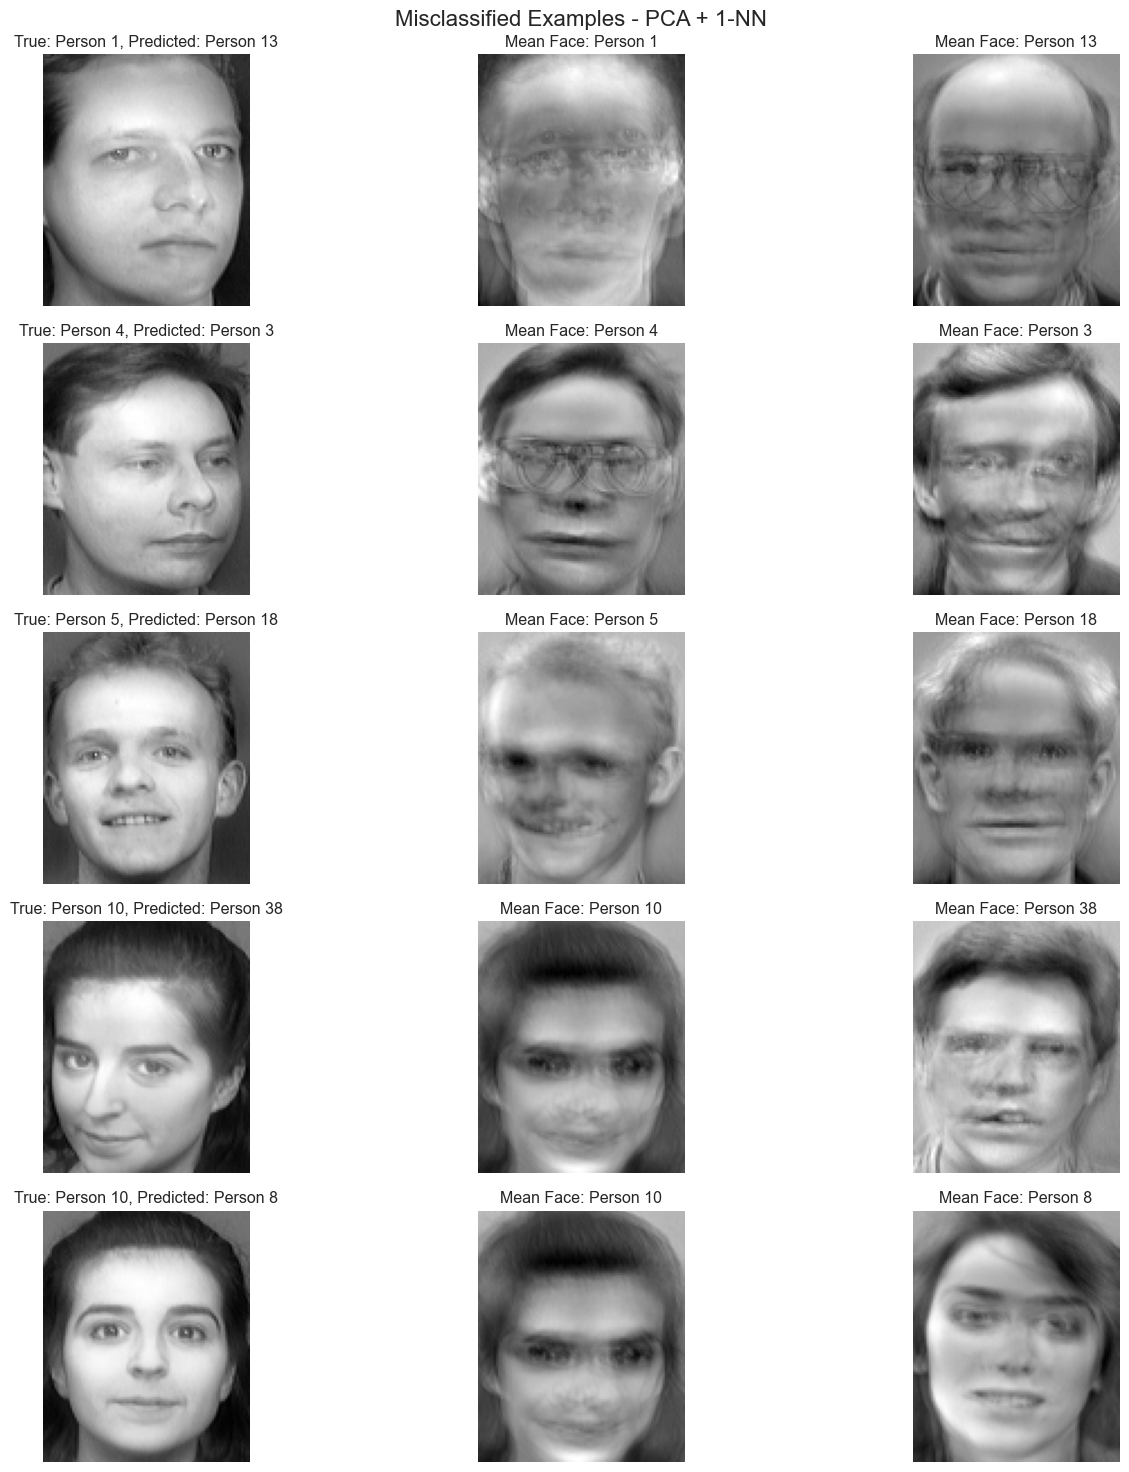

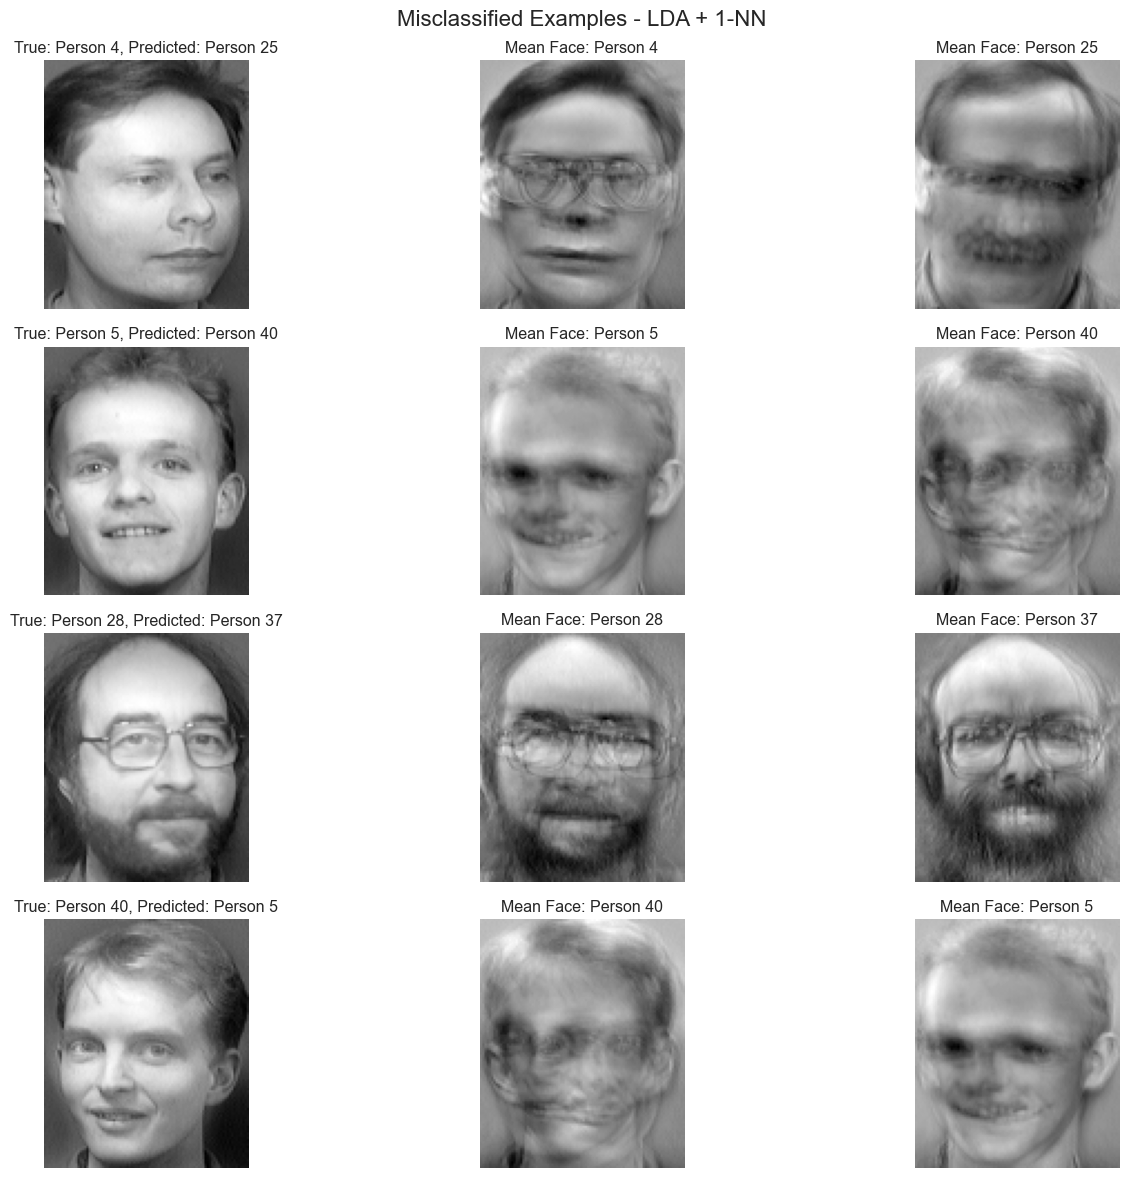

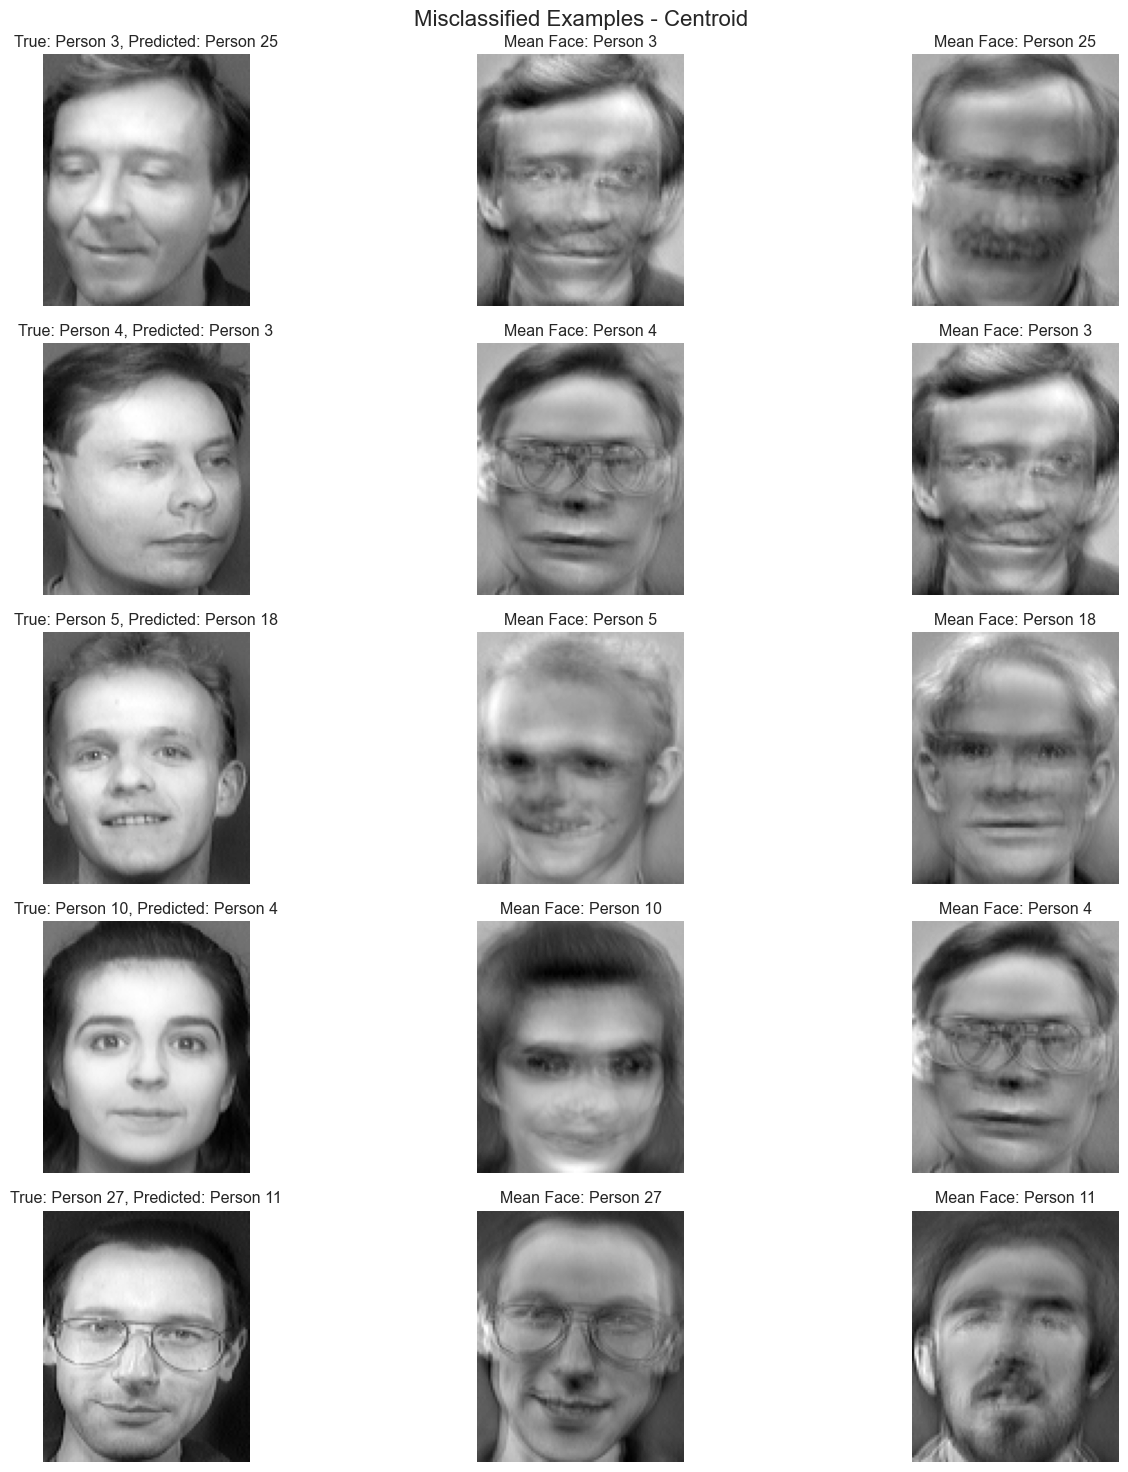

In [31]:
# Plot misclassified examples for each method
for name, pred in methods.items():
    n_errors = plot_misclassified_examples(X_test, y_test, pred, name, le)
    print(f"{name}: {n_errors} misclassifications out of {len(y_test)} test samples")

## 11. Summary and Conclusion

In [32]:
# Create a confusion matrix (may be large with many persons)
best_method = max(accuracies, key=accuracies.get)
best_pred = methods[best_method]

print(f"\nBest performing method: {best_method} with accuracy {accuracies[best_method]:.4f}")

# Print summary
print("\nAccuracy Summary:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")

print("\nAll visualizations saved to directory:", results_dir)


Best performing method: LDA + 1-NN with accuracy 0.9667

Accuracy Summary:
PCA + 1-NN: 0.9167
LDA + 1-NN: 0.9667
Centroid: 0.9083

All visualizations saved to directory: person_recognition_results
